<a href="https://colab.research.google.com/github/Mahnazshamissa/Python/blob/main/asigmo_ex2_groupE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab exercise 2


Per Group:
1.   Create a teams-meeting where one person opens the colab notebook and shares the screen (preferably a different person than yesterday)
2.   Change the network as described below. Different to yesterday you need to use Google and read the Tensorflow documention.
3.   Train the network, then plot the training history and evaluate it one the test set
4.   Replace the code that plots the training history by code that computes the best validation accuracy achieved during the training
5.   Post the best validation accuracy during and the test accuracy in the general Deep Learning teams channel
6.   Think about why your network performed better or worse compared to the ~73% accuracy of the baseline network
7.   In each group channel answer the questions below


- **Group A:** Add random zoom data augmentation (before the RandomCrop layer) and try it out with a height_factor of 0.1 and 0.2.
- **Group C:** Add L2 regularization with a factor of 0.0001 to the kernel of the convolutional layers. Try it out, then increase the learning rate to 0.001 and try it again
- **Group D:** Add [random flip data augmentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) before the rescaling layer. Try it out once with only horzontal flips and once with both horizontal and vertical flips 
- **Group E:** Add an spacial 2D dropout layer after the first MaxPool2D layer. Try is out with a dropout rate of 0.1 and 0.2


**Questions**
1.  How many training samples are fed through the network in each epochs? 
2.  How many weight updates (= training steps) are applied in our case in each epoch?
3.  How many training steps are applied in our case over the whole training process?
4.  Read the documentation of [```tf.keras.optimizers.schedules.PiecewiseConstantDecay```](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay). What does this module do?
5.  Which values for the argument ```boundaries``` and ```values``` do we need to set if we can a learning rate of 0.01 for the first 50 epochs, 0.001 for the next next 50 epochs and 0.0001 for the last 50 epochs?

**Info**: If your Colab notebook is training in the background (another tab), open it once in a while to avoid Colab from disconnecting the session!


## Setup notebook environment

Make sure the Colab environment has a GPU enabled *Edit->Notebook Settings->Hardware accelerator->Choose GPU*

In [ ]:
! nvidia-smi

Wed Oct 28 09:46:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Download the dataset first

In [ ]:
! wget https://pub.ist.ac.at/~mlechner/datasets/f8d.tar.gz
! tar -xf f8d.tar.gz

--2020-10-28 09:48:30--  https://pub.ist.ac.at/~mlechner/datasets/f8d.tar.gz
Resolving pub.ist.ac.at (pub.ist.ac.at)... 81.223.84.195
Connecting to pub.ist.ac.at (pub.ist.ac.at)|81.223.84.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76149807 (73M) [application/x-gzip]
Saving to: ‘f8d.tar.gz’

f8d.tar.gz          100%[===================>]  72.62M   972KB/s    in 98s     

2020-10-28 09:50:08 (758 KB/s) - ‘f8d.tar.gz’ saved [76149807/76149807]



Import python libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

## Step 1: Define datasets

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "f8d/test", shuffle=False, batch_size=128, image_size=(256, 256),
)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "f8d/training",
  shuffle=True,
  batch_size=64,
  image_size=(256, 256),
  validation_split=0.2,
  subset="training",
  seed=1020202,
)
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "f8d/training",
  shuffle=True,
  batch_size=128,
  image_size=(256, 256),
  validation_split=0.2,
  subset="validation",
  seed=1020202,
)
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 640 files belonging to 8 classes.
Found 1840 files belonging to 8 classes.
Using 1472 files for training.
Found 1840 files belonging to 8 classes.
Using 368 files for validation.


## Step 2 and 3: Define model and objective

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(256,256,3)),
  tf.keras.layers.experimental.preprocessing.RandomCrop(224, 224),
  tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
  tf.keras.layers.Conv2D(64, 7, strides=2, activation="relu", padding="same"),
  tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.SpatialDropout2D(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128,(4, 4), activation="relu", padding="same"),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256,(3, 3), activation="relu", padding="same"),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8,activation="softmax"),
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_crop (RandomCrop)     (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 56, 56, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 64)        2

## Step 4: Train the model

In [ ]:
training_log = model.fit(
  train_dataset, epochs=150, validation_data=valid_dataset
)

Epoch 1/150
23/23 [==============================] - 5s 208ms/step - loss: 2.0511 - sparse_categorical_accuracy: 0.2262 - val_loss: 2.0681 - val_sparse_categorical_accuracy: 0.1359
Epoch 2/150
23/23 [==============================] - 4s 153ms/step - loss: 1.9162 - sparse_categorical_accuracy: 0.2609 - val_loss: 2.0959 - val_sparse_categorical_accuracy: 0.1196
Epoch 3/150
23/23 [==============================] - 4s 155ms/step - loss: 1.7706 - sparse_categorical_accuracy: 0.3227 - val_loss: 2.1499 - val_sparse_categorical_accuracy: 0.1196
Epoch 4/150
23/23 [==============================] - 4s 155ms/step - loss: 1.7453 - sparse_categorical_accuracy: 0.3370 - val_loss: 2.5297 - val_sparse_categorical_accuracy: 0.1196
Epoch 5/150
23/23 [==============================] - 4s 153ms/step - loss: 1.6523 - sparse_categorical_accuracy: 0.3920 - val_loss: 2.6197 - val_sparse_categorical_accuracy: 0.1223
Epoch 6/150
23/23 [==============================] - 4s 153ms/step - loss: 1.5852 - sparse_cate

**Task:** Instead of plotting the training history, compute the best validation accuracy achieved during the entire training process

In [ ]:
valAcc = training_log.history["val_sparse_categorical_accuracy"]
#tf.math.maximum(training_log.history["val_sparse_categorical_accuracy"])
print(type(valAcc))
import numpy as np
valAccSeries = np.array(valAcc)
maxValAcc = np.max(valAcc)
maxValAccIdx = np.argmax(valAcc)
training_log.history["val_sparse_categorical_accuracy"]
print(maxValAcc)
print(maxValAccIdx)

<class 'list'>
0.782608687877655
126


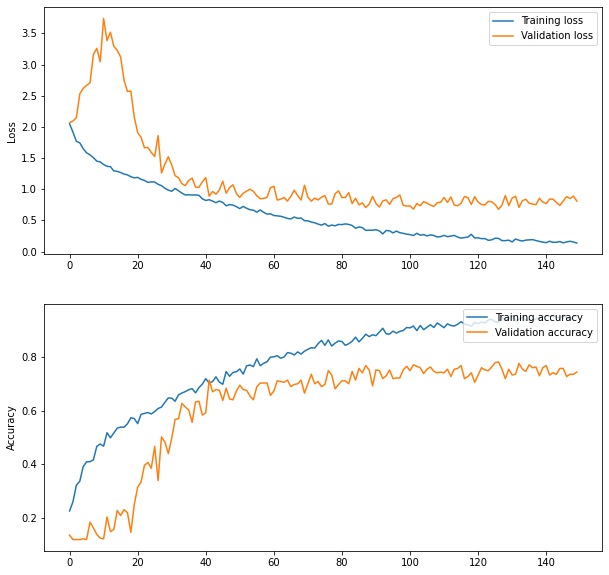

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(10,10))
axes[0].plot(training_log.history["loss"],label="Training loss")
axes[0].plot(training_log.history["val_loss"],label="Validation loss")
axes[0].legend(loc="upper right")
axes[0].set_ylabel("Loss")
axes[1].plot(training_log.history["sparse_categorical_accuracy"],label="Training accuracy")
axes[1].plot(training_log.history["val_sparse_categorical_accuracy"],label="Validation accuracy")
axes[1].legend(loc="upper right")
axes[1].set_ylabel("Accuracy")
fig.show()

## Step 5: Evaluate the model

In [ ]:
finalEval = model.evaluate(test_dataset)

5/5 [==============================] - 1s 173ms/step - loss: 1.0573 - sparse_categorical_accuracy: 0.7375


In [ ]:
print("the max validation accuracy is %f at epoch %d. The final accuracy is %f"
  %(maxValAcc,maxValAccIdx,finalEval[1]))

the max validation accuracy is 0.782609 at epoch 126. The final accuracy is 0.737500
